$\large{\textbf{Variational Autoencoders (VAE) with MNIST dataset}}$

To solidify my understanding of VAEs, I decided to implement the model myself. This notebook contains the tensorflow implementation of VAEs referenced from the paper [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf) by Kingma et al.. I also referenced the [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908) by Doersch while writing this code.

The general problem worked on by the paper is actually learning directed probabilistic models (e.g Bayesian Networks) whose continuous latent variables have intractable posterior distributions. Traditional approaches would require analytical solutions or approximations of the intractable posterior distribution, which are require expensive iterative inference schemes (e.g MCMC algorithms). In this paper, the authors propose reparameterizing the variational lower bound, yielding a differentiable unbiased estimator on it. This Stochastic Gradient Variational Bayes (SGVB) estimator can then be efficiently optimized using standard stochastic gradient ascent methods. 

Assuming an i.i.d dataset and continuous latent variables per datapoint, the authors proposed the Auto-Encoding VB (AEVB) algorithm. It uses the SGVB estimator to optimize a recognition model that uses ancestral sampling instead of expensive iterative inference schemes. When a neural network is used for the recognition model, the entire model is called the VAE. 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

# Unpack the MNIST dataset
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
mnist_x = mnist.train.images
mnist_y = mnist.train.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


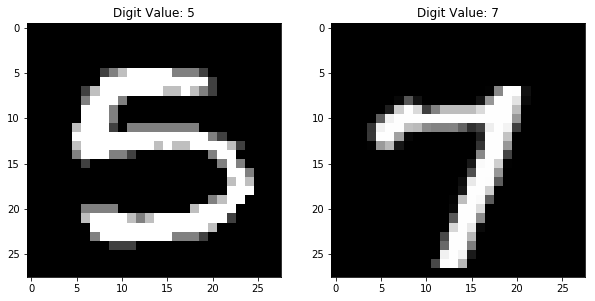

In [2]:
idx = np.random.randint(0, 55000, 2)

# Grayscale examples of the data we will be working with
f, ax = plt.subplots(1, 2, figsize=(10, 10));
ax[0].imshow(mnist_x[idx[0]].reshape(28, 28), cmap='gray');
ax[0].set(title='Digit Value: {}'.format(np.argmax(mnist_y[idx[0]])));
ax[1].imshow(mnist_x[idx[1]].reshape(28, 28), cmap='gray');
ax[1].set(title='Digit Value: {}'.format(np.argmax(mnist_y[idx[1]])));

The marginal likelihood can be written as:

<center>$log p_{\theta}(x^{(i)}) = D_{KL}(q_{\phi}(z | x^{(i)}) || p_{\theta}(z|x^{(i)})) + L(\theta, \phi; x^{(i)})$</center> where,

<center>$logp_{\theta}(x^{(i)}) \geq L(\theta, \phi; x^{(i)}) = E_{q_{\phi}(z|x)}[-logq_{\phi}(z|x) + log p_{\theta}(x,z)]$</center>
<center>$L(\theta, \phi; x^{(i)}) = -D_{KL}(q_{\phi}(z | x^{(i)}) || p_{\theta}(z)) + E_{q_{\phi}(z|x^{(i)})}[log p_{\theta}(x^{(i)},z)]$</center>

hence, to maximise the marginal likelihood w.r.t $\phi$ and $\theta$, we need to differentiate and optimize the lower bound, $L(\theta, \phi; x^{(i)})$.

One of the key ideas of this paper is the reparameterization of the random latent variable $z$ using a differentiable transformation of a noise variable, such that:

<center>$z \sim g_{\phi}(\epsilon, x)$ with $\epsilon \sim p(\epsilon)$</center>

Instead of having a discontinuous feedforward process by sampling a $z \sim q_{\phi}(z | x)$ to input to the decoder network, we are now able to get rid oft he discontinuity and allow the entire VAE to be trained by backpropagation.

In this example, I will implement the networks described in the paper and try to recreate the results shown in the paper. For the MNIST dataset, a Gaussian MLP is used for the encoder network and a Bernoulli MLP is used for the decoder network.

Model saved in file: ./tmp/model_0.ckpt
Model saved in file: ./tmp/model_1.ckpt
Model saved in file: ./tmp/model_2.ckpt
Model saved in file: ./tmp/model_3.ckpt


(0.0, 1.0, 0.0, 1.0)

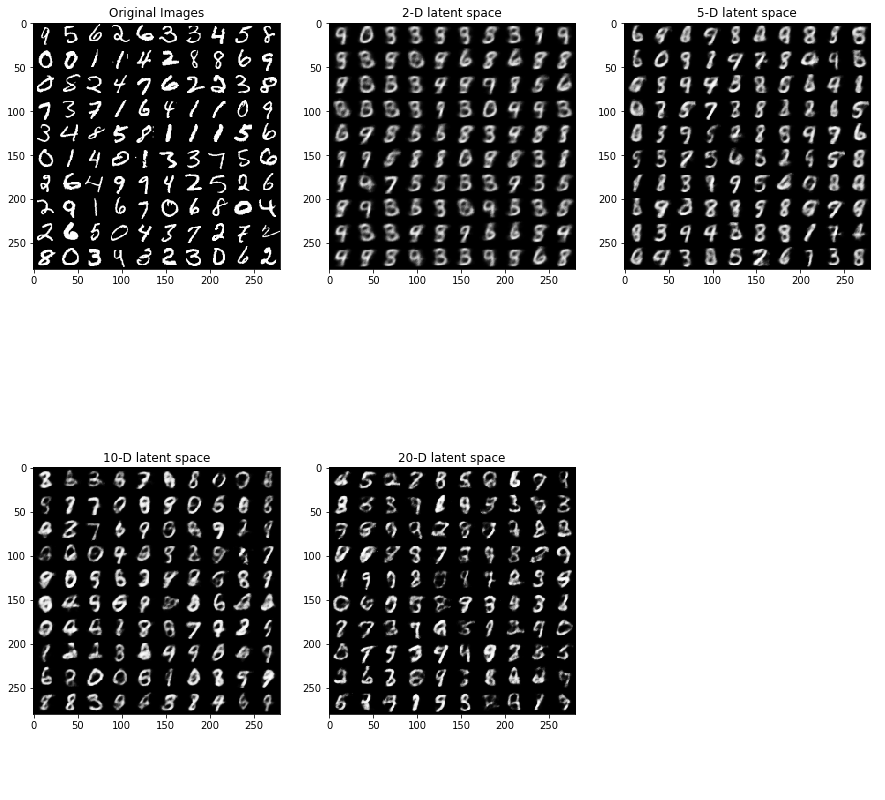

In [8]:
# Some dimensions for the VAE network
MNIST_dim = 784
hidden_dim = 500
latent_dim_vec = [2, 5, 10, 20]

batch_size = 100
num_iterations = 10000

f1, ax1 = plt.subplots(2, 3, figsize=(15, 15));
viz_data = mnist.train.images[np.random.choice(55000, 100), :]

n = 10  # figure with 20x20 digits
digit_size = 28
meshgrid = np.zeros((digit_size * n, digit_size * n))

for i in range(n):
    for j in range(n):
        digit = viz_data[i*n + j, :].reshape(digit_size, digit_size)
        meshgrid[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

ax1[0,0].imshow(meshgrid, cmap='gray')
ax1[0,0].set(title='Original Images');

for idx, latent_dim in enumerate(latent_dim_vec):
    # Reset
    tf.reset_default_graph()

    # Inputs to the network
    x = tf.placeholder(tf.float32, [None, MNIST_dim])

    # Encoder network (Gaussian MLP)
    encoder_hidden_w = tf.Variable(tf.random_normal([MNIST_dim, hidden_dim], mean=0.0, stddev=0.01))
    encoder_hidden_b = tf.Variable(tf.random_normal([hidden_dim], mean=0.0, stddev=0.01))
    encoder_hidden_h = tf.tanh(tf.matmul(x, encoder_hidden_w) + encoder_hidden_b)

    encoder_mu_w = tf.Variable(tf.random_normal([hidden_dim, latent_dim], mean=0.0, stddev=0.01))
    encoder_mu_b = tf.Variable(tf.random_normal([latent_dim], mean=0.0, stddev=0.01))
    encoder_mu = tf.matmul(encoder_hidden_h, encoder_mu_w) + encoder_mu_b

    encoder_sigma_w = tf.Variable(tf.random_normal([hidden_dim, latent_dim], mean=0.0, stddev=0.01))
    encoder_sigma_b = tf.Variable(tf.random_normal([latent_dim], mean=0.0, stddev=0.01))
    encoder_logvar = tf.matmul(encoder_hidden_h, encoder_sigma_w) + encoder_sigma_b

    # Latent variables
    z = encoder_mu + tf.exp(0.5 * encoder_logvar) * tf.random_normal(tf.shape(encoder_logvar), mean=0.0, stddev=1.0, dtype=tf.float32)

    # Decoder network (Bernoulli MLP)
    decoder_hidden_w = tf.Variable(tf.random_normal([latent_dim, hidden_dim], mean=0.0, stddev=0.01))
    decoder_hidden_b = tf.Variable(tf.random_normal([hidden_dim], mean=0.0, stddev=0.01))
    decoder_hidden_h = tf.tanh(tf.matmul(z, decoder_hidden_w) + decoder_hidden_b)

    decoder_xhat_w = tf.Variable(tf.random_normal([hidden_dim, MNIST_dim], mean=0.0, stddev=0.01))
    decoder_xhat_b = tf.Variable(tf.random_normal([MNIST_dim], mean=0.0, stddev=0.01))
    decoder_xhat = tf.sigmoid(tf.matmul(decoder_hidden_h, decoder_xhat_w) + decoder_xhat_b)

    # Objective function
    KLD = -0.5 * tf.reduce_sum(1 + encoder_logvar - tf.pow(encoder_mu, 2) - tf.exp(encoder_logvar), reduction_indices=1)
    likelihood = tf.reduce_sum(x * tf.log(decoder_xhat) + (1 - x) * tf.log(1 - decoder_xhat) , reduction_indices=1)
    loss = tf.reduce_mean(KLD - likelihood)
    tf.summary.scalar('loss', loss)

    # Training optimizer
    train_step = tf.train.AdamOptimizer(0.01).minimize(loss)

    merged = tf.summary.merge_all()

    saver = tf.train.Saver()
    with tf.Session() as sess:
        writer = tf.summary.FileWriter('./tmp/MNIST', sess.graph)
        tf.global_variables_initializer().run()

        for i in range(num_iterations):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            _, batch_loss, summary = sess.run([train_step, loss, merged], feed_dict={x: batch_xs})
            writer.add_summary(summary, i)

        # Save the variables to disk.
        save_path = saver.save(sess, "./tmp/model_{}.ckpt".format(idx))
        print("Model saved in file: %s" % save_path)

        for i in range(n):
            for j in range(n):
                z_sample = np.random.normal(size=latent_dim)
                x_reconstructed = sess.run(decoder_xhat, feed_dict={z: z_sample.reshape(1, latent_dim)})
                digit = x_reconstructed[0].reshape(digit_size, digit_size)
                meshgrid[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit


        ax1[int((idx+1)/3), (idx+1)%3].imshow(meshgrid, cmap='gray')
        ax1[int((idx+1)/3), (idx+1)%3].set(title='{}-D latent space'.format(latent_dim));

ax1[-1, -1].axis('off')

This is an example result of a reconstructed image generated from $z \sim N(0, I)$.

INFO:tensorflow:Restoring parameters from ./tmp/model_0.ckpt


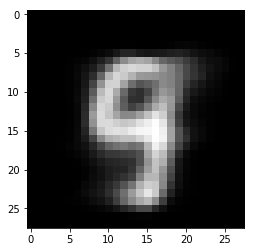

In [10]:
latent_dim = 2

# Reset
tf.reset_default_graph()

# Inputs to the network
x = tf.placeholder(tf.float32, [None, MNIST_dim])

# Encoder network (Gaussian MLP)
encoder_hidden_w = tf.Variable(tf.random_normal([MNIST_dim, hidden_dim], mean=0.0, stddev=0.01))
encoder_hidden_b = tf.Variable(tf.random_normal([hidden_dim], mean=0.0, stddev=0.01))
encoder_hidden_h = tf.tanh(tf.matmul(x, encoder_hidden_w) + encoder_hidden_b)

encoder_mu_w = tf.Variable(tf.random_normal([hidden_dim, latent_dim], mean=0.0, stddev=0.01))
encoder_mu_b = tf.Variable(tf.random_normal([latent_dim], mean=0.0, stddev=0.01))
encoder_mu = tf.matmul(encoder_hidden_h, encoder_mu_w) + encoder_mu_b

encoder_sigma_w = tf.Variable(tf.random_normal([hidden_dim, latent_dim], mean=0.0, stddev=0.01))
encoder_sigma_b = tf.Variable(tf.random_normal([latent_dim], mean=0.0, stddev=0.01))
encoder_logvar = tf.matmul(encoder_hidden_h, encoder_sigma_w) + encoder_sigma_b

# Latent variables
z = encoder_mu + tf.exp(0.5 * encoder_logvar) * tf.random_normal(tf.shape(encoder_logvar), mean=0.0, stddev=1.0, dtype=tf.float32)

# Decoder network (Bernoulli MLP)
decoder_hidden_w = tf.Variable(tf.random_normal([latent_dim, hidden_dim], mean=0.0, stddev=0.01))
decoder_hidden_b = tf.Variable(tf.random_normal([hidden_dim], mean=0.0, stddev=0.01))
decoder_hidden_h = tf.tanh(tf.matmul(z, decoder_hidden_w) + decoder_hidden_b)

decoder_xhat_w = tf.Variable(tf.random_normal([hidden_dim, MNIST_dim], mean=0.0, stddev=0.01))
decoder_xhat_b = tf.Variable(tf.random_normal([MNIST_dim], mean=0.0, stddev=0.01))
decoder_xhat = tf.sigmoid(tf.matmul(decoder_hidden_h, decoder_xhat_w) + decoder_xhat_b)

# Objective function
KLD = -0.5 * tf.reduce_sum(1 + encoder_logvar - tf.pow(encoder_mu, 2) - tf.exp(encoder_logvar), reduction_indices=1)
likelihood = tf.reduce_sum(x * tf.log(decoder_xhat) + (1 - x) * tf.log(1 - decoder_xhat) , reduction_indices=1)
loss = tf.reduce_mean(KLD - likelihood)
tf.summary.scalar('loss', loss)

# Training optimizer
train_step = tf.train.AdamOptimizer(0.01).minimize(loss)

merged = tf.summary.merge_all()

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./tmp/model_0.ckpt")
    z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
    x_reconstructed = sess.run(decoder_xhat, feed_dict={z: z_sample})
    
    plt.imshow(x_reconstructed.reshape(28, 28), cmap='gray')

Below is a visualization of the clustering patterns of the latent variables of the training images in 2-dimensions.

INFO:tensorflow:Restoring parameters from ./tmp/model_0.ckpt


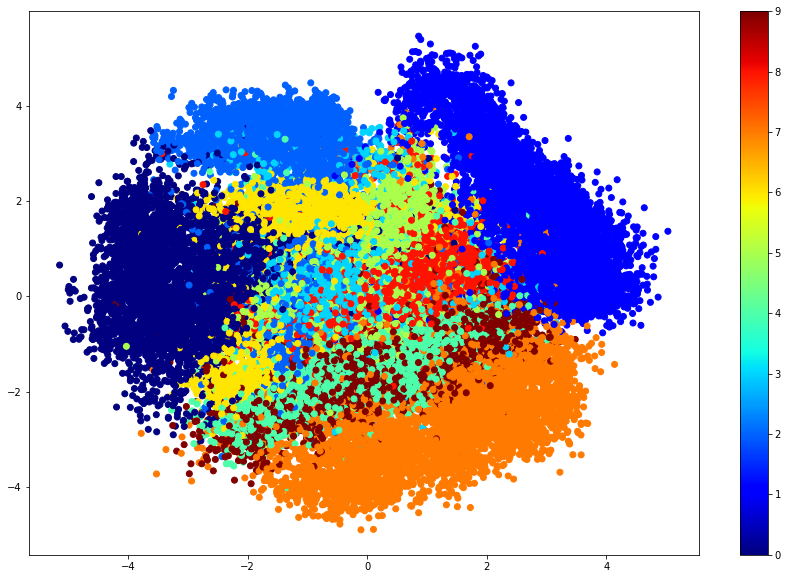

In [11]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./tmp/model_0.ckpt")
    latent_vec = sess.run(z, feed_dict={x: mnist.train.images})
    
    plt.figure(figsize=(15, 10))
    plt.scatter(x=latent_vec[:,0], y=latent_vec[:,1], c=np.argmax(mnist.train.labels, axis=1), cmap='jet')
    plt.colorbar()

INFO:tensorflow:Restoring parameters from ./tmp/model_0.ckpt


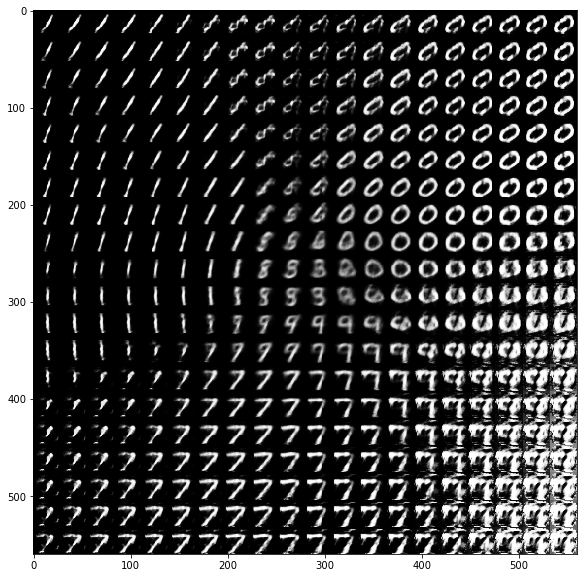

In [6]:
# Taken from https://blog.keras.io/building-autoencoders-in-keras.html

# display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-10, 10] standard deviations
grid_x = np.linspace(-10, 10, n)
grid_y = np.linspace(-10, 10, n)

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./tmp/model_0.ckpt")
    
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_reconstructed = sess.run(decoder_xhat, feed_dict={z: z_sample})
            digit = x_reconstructed[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')

Conclusions:

The images generated obtained are not extremely close to the ones in the paper. I have looked around at several other code examples on the web and it appears that they used activation functions and architectures that differ from the paper. I believe if I were to use 1 more layer each for both the encoder and the decoder and the ReLU activation function for the hidden layers, I would be getting much better results. However, following the parameters and architectures described in the paper, I am able to obtain decent results.